In [2]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

Using write.csv in R, I exported the dataset from package 'ISLR' to a csv file.

In [3]:
df = pd.read_csv('Data/Wage.csv')
df.head(3)

   Unnamed: 0  year  age      sex            maritl      race  \
0      231655  2006   18  1. Male  1. Never Married  1. White   
1       86582  2004   24  1. Male  1. Never Married  1. White   
2      161300  2003   45  1. Male        2. Married  1. White   

         education              region        jobclass          health  \
0     1. < HS Grad  2. Middle Atlantic   1. Industrial       1. <=Good   
1  4. College Grad  2. Middle Atlantic  2. Information  2. >=Very Good   
2  3. Some College  2. Middle Atlantic   1. Industrial       1. <=Good   

  health_ins   logwage        wage  
0      2. No  4.318063   75.043154  
1      2. No  4.255273   70.476020  
2     1. Yes  4.875061  130.982177  

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 13 columns):
Unnamed: 0    3000 non-null int64
year          3000 non-null int64
age           3000 non-null int64
sex           3000 non-null object
maritl        3000 non-null object
race          3000 non-null object
education     3000 non-null object
region        3000 non-null object
jobclass      3000 non-null object
health        3000 non-null object
health_ins    3000 non-null object
logwage       3000 non-null float64
wage          3000 non-null float64
dtypes: float64(2), int64(3), object(8)
memory usage: 234.4+ KB


## Lab

### § 7.8.1 Polynomial Regression and Step Functions

Create polynomials for 'age'.

In [5]:
X1 = PolynomialFeatures(1).fit_transform(df.age.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.reshape(-1,1))

y = (df.wage > 250).map({False:0, True:1}).as_matrix()
print('X4:\n', X4[:5])
print('y:\n', y[:5])

X4:
 [[      1      18     324    5832  104976]
 [      1      24     576   13824  331776]
 [      1      45    2025   91125 4100625]
 [      1      43    1849   79507 3418801]
 [      1      50    2500  125000 6250000]]
y:
 [0 0 0 0 0]


#### Linear regression model. (Degree 4)

In [6]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,-184.1542,60.040,-3.067,0.002,-301.879 -66.430
x1,21.2455,5.887,3.609,0.000,9.703 32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968 -0.160
x3,0.0068,0.003,2.221,0.026,0.001 0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05 1.45e-07


Selecting a suitable degree for the polynomial of age.

In [7]:
fit_1 = fit = sm.GLS(df.wage, X1).fit()
fit_2 = fit = sm.GLS(df.wage, X2).fit()
fit_3 = fit = sm.GLS(df.wage, X3).fit()
fit_4 = fit = sm.GLS(df.wage, X4).fit()
fit_5 = fit = sm.GLS(df.wage, X5).fit()

sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5, typ=1)

   df_resid             ssr  df_diff        ss_diff           F        Pr(>F)
0      2998  5022216.104743        0            NaN         NaN           NaN
1      2997  4793430.094614        1  228786.010129  143.593107  2.363850e-32
2      2996  4777674.400950        1   15755.693664    9.888756  1.679202e-03
3      2995  4771604.248826        1    6070.152124    3.809813  5.104620e-02
4      2994  4770321.685810        1    1282.563017    0.804976  3.696820e-01

The polynomial degree 4 seems best.

In [8]:
X = X4

Scikit-learn implements a regularized logistic regression model particularly suitable for high dimensional data. Since we just have one feature (age) we use the GLM model from statsmodels.

In [9]:
clf = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

Create array of test data. Transform to polynomial degree 4.

In [10]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

X_test = PolynomialFeatures(4).fit_transform(age_grid)
X_test[:5]

array([[     1,     18,    324,   5832, 104976],
       [     1,     19,    361,   6859, 130321],
       [     1,     20,    400,   8000, 160000],
       [     1,     21,    441,   9261, 194481],
       [     1,     22,    484,  10648, 234256]])

In [11]:
pred = res.predict(X_test)

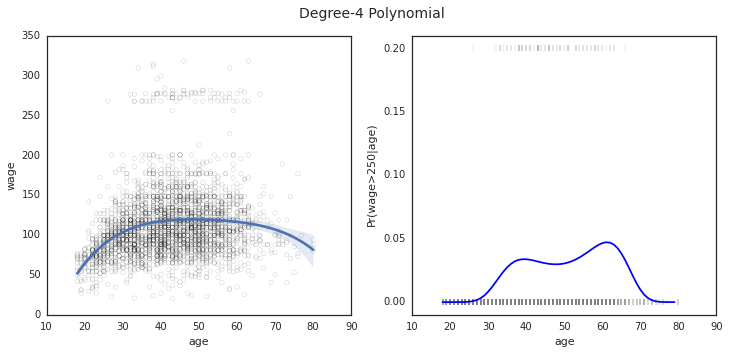

In [89]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

#### Step function

In [23]:
df_cut, bins = pd.cut(df.age, 4, retbins=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49]        1399
(49, 64.5]         779
(64.5, 80]          72
dtype: int64

In [14]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)
df_steps.head(5)

   age        age_cuts        wage
0   18  (17.938, 33.5]   75.043154
1   24  (17.938, 33.5]   70.476020
2   45      (33.5, 49]  130.982177
3   43      (33.5, 49]  154.685293
4   50      (49, 64.5]   75.043154

In [18]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

df_steps_dummies.head(5)

   const  (17.938, 33.5]  (33.5, 49]  (49, 64.5]  (64.5, 80]
0      1               1           0           0           0
1      1               1           0           0           0
2      1               0           1           0           0
3      1               0           1           0           0
4      1               0           0           1           0

In [19]:
# Using statsmodels because it has a more complete output for coefficients
fit3 = sm.GLS(df_steps.wage, df_steps_dummies.drop(['(17.938, 33.5]'], axis=1)).fit()
fit3.summary().tables[1]

,coef,std err,t,P>|t|,[95.0% Conf. Int.]
const,94.1584,1.476,63.790,0.000,91.264 97.053
"(33.5, 49]",24.0535,1.829,13.148,0.000,20.466 27.641
"(49, 64.5]",23.6646,2.068,11.443,0.000,19.610 27.719
"(64.5, 80]",7.6406,4.987,1.532,0.126,-2.139 17.420


In [76]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32)

In [79]:
# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_test2.head()

   const  2  3  4
0      1  0  0  0
1      1  0  0  0
2      1  0  0  0
3      1  0  0  0
4      1  0  0  0

#### Linear Regression

In [80]:
pred2 = fit3.predict(X_test2)

#### Logistic Regression

In [82]:
clf2 = sm.GLM(y, df_steps_dummies.drop(['(17.938, 33.5]'], axis=1), family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

### Figure 7.2

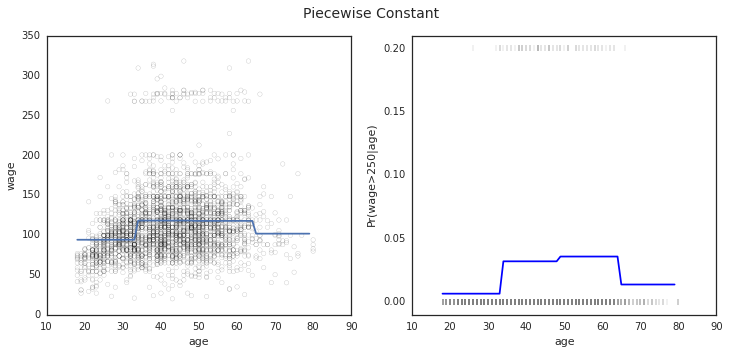

In [90]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')